**Выводы**

Решил самостоятельно имплементировать `SegNet` и `BinaryDiceLoss`. Результаты средние, но опыт считаю очень интересным и полезным. Обучал с тремя функциями потерь:
1. `BinaryDiceLoss` - не обучается
2. `BCEWithLogitsLoss` - после 10 эпох начинает что-то сегментировать, но всё равно средне
3. `BCEWithLogitsLoss` + `BinaryDiceLoss` - после 10 эпох начинает что-то сегментировать. Лосс больше, но `mean-IoU` такой же, как в пункте 2

`NewSegNet` - добавил `torch.sigmoid()` в конце метода `forward()`, чтобы масштабировать результаты на [0, 1]
- Лоссы такие же, как в пункте 2
- `mean-IoU` меньше, но сами картинки выглядят так, словно сегментируются лучше

In [1]:
%%capture
!pip install opencv-python torch torchvision

In [ ]:
%%bash
wget https://data.deepai.org/PascalVOC2012.zip
unzip PascalVOC2012.zip
mv voc2012 VOCdevkit

In [5]:
import random
import numpy as np

import torch
import torchvision
import torchvision.transforms.v2 as tf
from torchvision.datasets import VOCSegmentation

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [41]:
class SegmentationTransform:
    """
    Применяет одни и те же аугментации к изображению и к маске.
    В итоговой маске два класса: объект и фон
    """
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image, mask):
        seed = random.randint(0, 2**32)

        torch.manual_seed(seed)
        image = self.transform(image)

        torch.manual_seed(seed)
        mask = self.transform(mask)
        mask = (mask != 0).type(torch.float)

        return image, mask


class CustomVOCDataset(Dataset):
    def __init__(self, train=False, train_size=0.8, custom_transform=None,       # custom args
                 root='.', year='2012', image_set='trainval', download=False):

        self._dataset = VOCSegmentation(root, year, image_set, download)
        self._custom_transform = custom_transform

        indices = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(indices)
        train_part = int(len(indices) * train_size)
        self._indices = indices[:train_part] if train else indices[train_part:]

    def __len__(self):
        return len(self._indices)

    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]

        if self._custom_transform is not None:
            image, mask = self._custom_transform(image, mask)

        return image, mask


IMAGE_SIZE = 256
BATCH_SIZE = 2

train_transform = tf.Compose([
    tf.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    tf.RandomHorizontalFlip(p=0.5),
    tf.RandomVerticalFlip(p=0.5),
    tf.RandomRotation((-15, 15)),
    tf.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    tf.ToTensor(),
])
val_transform = tf.Compose([
    tf.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    tf.ToTensor(),
])


train_transform = SegmentationTransform(train_transform)
val_transform = SegmentationTransform(val_transform)

train_dataset = CustomVOCDataset(train=True, custom_transform=train_transform)
val_dataset = CustomVOCDataset(train=False, custom_transform=val_transform)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_dataset), len(val_dataset))

2330 583


In [ ]:
img, mask = train_dataset[0]

plt.imshow(img.permute(1, 2, 0))

In [ ]:
plt.imshow(mask.permute(1, 2, 0))

In [ ]:
img, mask = val_dataset[0]

plt.imshow(img.permute(1, 2, 0))

In [ ]:
plt.imshow(mask.permute(1, 2, 0))

In [7]:
class SegNet(nn.Module):
    @staticmethod
    def make_layers_down(in_channels, hidden_channels, extra_conv=False):
        """Создаёт блок энкодера из двух или трёх сверток"""

        layers = [
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU()
        ]

        if extra_conv:
            layers.extend([
                nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(hidden_channels),
                nn.ReLU()
            ])

        enc_conv = nn.Sequential(*layers)
        pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        return enc_conv, pool

    @staticmethod
    def make_layers_up(in_channels, hidden_channels, extra_conv=False):
        """Создаёт блок декодера из двух или трёх сверток"""

        upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU()
        ]

        if extra_conv:
            layers = [
                nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(in_channels),
                nn.ReLU()
            ] + layers

        dec_conv = nn.Sequential(*layers)
        return upsample, dec_conv

    def __init__(self, num_classes, hidden_channels):
        super().__init__()
        self.num_classes = num_classes
        self.hidden_channels = hidden_channels

        """ENCODER. 5 stages"""
        # feature map 3 --> 64
        self.enc_conv0, self.pool0 = SegNet.make_layers_down(3, self.hidden_channels)

        # feature map 64 --> 128
        self.enc_conv1, self.pool1 = SegNet.make_layers_down(
            self.hidden_channels,
            self.hidden_channels * 2,
            True
        )

        # feature map 128 --> 256
        self.enc_conv2, self.pool2 = SegNet.make_layers_down(
            self.hidden_channels * 2,
            self.hidden_channels * 4,
            True
        )

        # feature map 256 --> 512
        self.enc_conv3, self.pool3 = SegNet.make_layers_down(
            self.hidden_channels * 4,
            self.hidden_channels * 8,
            True
        )

        # feature map 512 --> 512
        self.enc_conv4, self.pool4 = SegNet.make_layers_down(
            self.hidden_channels * 8,
            self.hidden_channels * 8,
            True
        )

        """DECODER. 5 stages correspond to their counterparts in ENCODER"""
        # feature map 512 --> 512
        self.upsample4, self.dec_conv4 = SegNet.make_layers_up(
            self.hidden_channels * 8,
            self.hidden_channels * 8,
            True
        )

        # feature map 512 --> 256
        self.upsample3, self.dec_conv3 = SegNet.make_layers_up(
            self.hidden_channels * 8,
            self.hidden_channels * 4,
            True
        )

        # feature map 256 --> 128
        self.upsample2, self.dec_conv2 = SegNet.make_layers_up(
            self.hidden_channels * 4,
            self.hidden_channels * 2,
            True
        )

        # feature map 128 --> 64
        self.upsample1, self.dec_conv1 = SegNet.make_layers_up(
            self.hidden_channels * 2,
            self.hidden_channels,
        )

        # feature map 64 --> num_classes
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(
                self.hidden_channels,
                self.hidden_channels,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(self.hidden_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(
                self.hidden_channels,
                self.num_classes,
                kernel_size=3,
                padding=1
            )
        )

    def forward(self, x):
        # ENCODING
        x, idx0 = self.pool0(self.enc_conv0(x))
        size0 = x.size()

        x, idx1 = self.pool1(self.enc_conv1(x))
        size1 = x.size()

        x, idx2 = self.pool2(self.enc_conv2(x))
        size2 = x.size()

        x, idx3 = self.pool3(self.enc_conv3(x))
        size3 = x.size()

        x, idx4 = self.pool4(self.enc_conv4(x))

        # DECODING
        x = self.dec_conv4(self.upsample4(x, idx4, output_size=size3))
        x = self.dec_conv3(self.upsample3(x, idx3, output_size=size2))
        x = self.dec_conv2(self.upsample2(x, idx2, output_size=size1))
        x = self.dec_conv1(self.upsample1(x, idx1, output_size=size0))
        x = self.dec_conv0(self.upsample0(x, idx0))

        return x

In [ ]:
model = SegNet(num_classes=1, hidden_channels=64)

for elem in train_dataloader:
    img, mask = elem
    break

output = model(img)
print(f"{mask.shape = }")
print(f"{output.shape = }")

mask.shape = torch.Size([2, 1, 512, 512])
output.shape = torch.Size([2, 1, 512, 512])


In [19]:
def mean_iou(y_pred, y_true, num_classes=2):
    """метрика mean-IoU"""

    y_pred = (torch.sigmoid(y_pred) > 0.5).float()
    iou_list = []

    for cls in range(num_classes):
        intersection = ((y_pred == cls) & (y_true == cls)).sum().item()
        union = ((y_pred == cls).sum() + (y_true == cls).sum() - intersection).item()

        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union

        iou_list.append(iou)

    return torch.tensor(iou_list).mean()

In [20]:
from torch.autograd import Variable


class BinaryDiceLoss(nn.Module):
    """функция потерь Dice Loss"""
    def __init__(self, smooth=1e-6):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = (y_pred > 0.5).float()
        numerator = 2.0 * (y_pred * y_true).sum() + self.smooth
        denominator = y_pred.sum() + y_true.sum() + self.smooth
        dice_coef = numerator / denominator
        dice_coef = Variable((1 - dice_coef).data, requires_grad=True)
        return dice_coef

In [21]:
bce_loss_func = nn.BCEWithLogitsLoss()


def binary_dice_loss(preds, targets, smooth=1e-6):
    """функция потерь Dice Loss"""
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    return 1 - (2.0 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)


def combined_loss(preds, targets):
    """комбинация BCEWithLogitsLoss и Dice Loss"""
    bce_loss = bce_loss_func(preds, targets)
    dice_loss = binary_dice_loss(preds, targets)
    return bce_loss + dice_loss

In [38]:
def train_one_epoch(model, dataloader, optimizer, loss_func, metric_func, device):
    model = model.to(device)
    model.train()
    epoch_loss, epoch_metric = 0, 0

    for image, mask in dataloader:
        optimizer.zero_grad()
        image = image.to(device)
        mask = mask.to(device)

        output = model(image)
        loss = loss_func(output, mask)
        metric = metric_func(output, mask)

        epoch_loss += loss.item()
        epoch_metric += metric.item()

        loss.backward()
        optimizer.step()

    epoch_loss /= len(dataloader)
    epoch_metric /= len(dataloader)
    return epoch_loss, epoch_metric


def eval_one_epoch(model, dataloader, loss_func, metric_func, device):
    model = model.to(device)
    model.eval()
    epoch_loss, epoch_metric = 0, 0

    for image, mask in dataloader:
        image = image.to(device)
        mask = mask.to(device)

        with torch.no_grad():
            output = model(image)

        loss = loss_func(output, mask)
        metric = metric_func(output, mask)

        epoch_loss += loss.item()
        epoch_metric += metric.item()

    epoch_loss /= len(dataloader)
    epoch_metric /= len(dataloader)
    return epoch_loss, epoch_metric


def train(model, train_dataloader, val_dataloader, optimizer, loss_func, metric_func, device, epochs):
    train_loss_history, train_metric_history = [], []
    val_loss_history, val_metric_history = [], []

    for epoch in tqdm(range(epochs)):
        train_loss, train_metric = train_one_epoch(
            model, train_dataloader,
            optimizer, loss_func,
            metric_func, device
        )
        val_loss, val_metric = eval_one_epoch(
            model, val_dataloader,
            loss_func, metric_func, device
        )

        print(f"EPOCH: {epoch + 1}, train_loss: {train_loss:.4f}, train_metric: {train_metric:.4f}")
        print(f"EPOCH: {epoch + 1}, val_loss: {val_loss:.4f}, val_metric: {val_metric:.4f}")

        train_loss_history.append(train_loss)
        train_metric_history.append(train_metric)
        val_loss_history.append(val_loss)
        val_metric_history.append(val_metric)

    result = {
        'train_loss': train_loss_history,
        'train_metric': train_metric_history,
        'val_loss': val_loss_history,
        'val_metric': val_metric_history,
    }

    return result

In [11]:
def draw_results(model, dataloader, device, k):
    for i, (image, mask) in enumerate(dataloader):
        if i == k - 1:
            break
        image = image.to(device)
        output = model(image)
        for i in range(len(output)):
            f, (ax1, ax2, ax3) = plt.subplots(1, 3)
            f.set_figheight(10)
            f.set_figwidth(30)
            ax1.imshow(mask[i].permute(1, 2, 0))
            ax1.set_title('true mask')

            ax2.imshow(image[i].permute(1, 2, 0).detach().cpu().numpy())
            ax2.set_title('image')

            ax3.imshow(output[i].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
            ax3.set_title('pred mask')

            plt.show()

In [17]:
def plotting(values: list, title: str):
    x = list(range(1, len(values) + 1))
    plt.plot(x, values)
    plt.title(title)
    plt.show()

**BinaryDiceLoss**

In [ ]:
model = SegNet(num_classes=1, hidden_channels=64)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss = BinaryDiceLoss()
metric = mean_iou
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10

In [ ]:
# dice loss
result = train(model, train_dataloader, val_dataloader, optimizer, loss, mean_iou, device, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1, train_loss: 0.3046, train_metric: 0.1026
EPOCH: 1, val_loss: 0.2933, val_metric: 0.1074
EPOCH: 2, train_loss: 0.3036, train_metric: 0.1029
EPOCH: 2, val_loss: 0.2942, val_metric: 0.1073
EPOCH: 3, train_loss: 0.3048, train_metric: 0.1025
EPOCH: 3, val_loss: 0.2935, val_metric: 0.1076
EPOCH: 4, train_loss: 0.3040, train_metric: 0.1028
EPOCH: 4, val_loss: 0.2942, val_metric: 0.1072
EPOCH: 5, train_loss: 0.3043, train_metric: 0.1027
EPOCH: 5, val_loss: 0.2938, val_metric: 0.1074
EPOCH: 6, train_loss: 0.3038, train_metric: 0.1028
EPOCH: 6, val_loss: 0.2945, val_metric: 0.1073
EPOCH: 7, train_loss: 0.3046, train_metric: 0.1026
EPOCH: 7, val_loss: 0.2928, val_metric: 0.1076
EPOCH: 8, train_loss: 0.3036, train_metric: 0.1029
EPOCH: 8, val_loss: 0.2946, val_metric: 0.1075
EPOCH: 9, train_loss: 0.3043, train_metric: 0.1026
EPOCH: 9, val_loss: 0.2931, val_metric: 0.1070
EPOCH: 10, train_loss: 0.3044, train_metric: 0.1025
EPOCH: 10, val_loss: 0.2939, val_metric: 0.1073


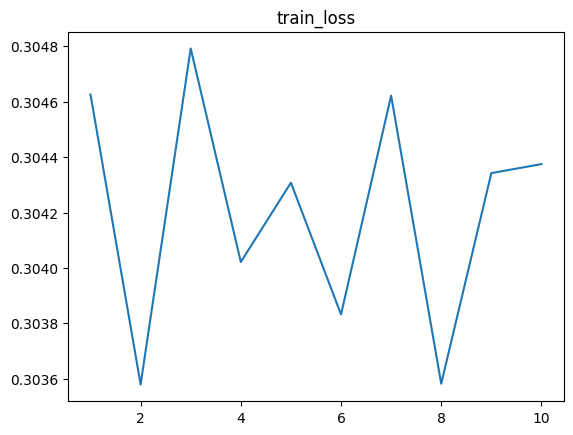

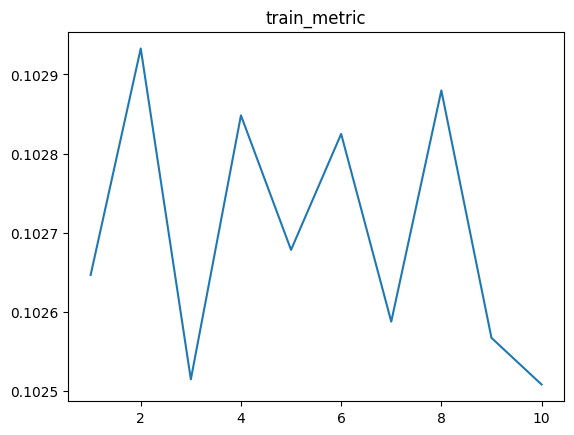

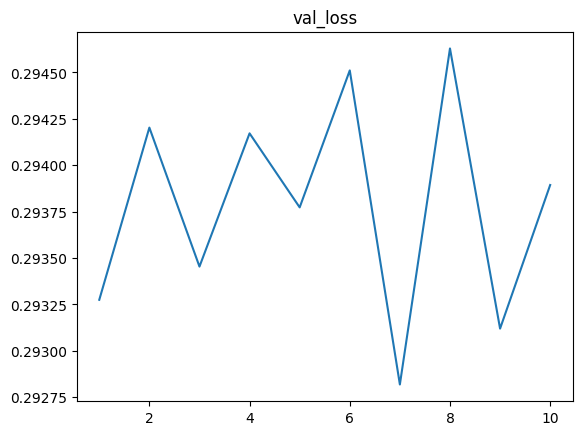

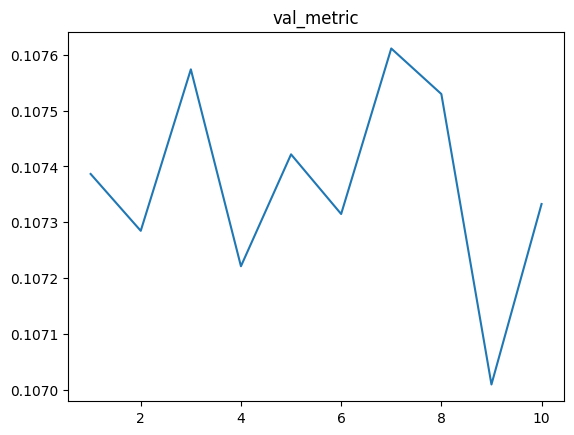

In [18]:
for key, value in result.items():
    plotting(value, key)

In [ ]:
draw_results(model, val_dataloader, device, 2)

Output hidden; open in https://colab.research.google.com to view.

**BCEWithLogitsLoss**

In [12]:
model = SegNet(num_classes=1, hidden_channels=64)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss = nn.BCEWithLogitsLoss()
metric = mean_iou
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10

In [13]:
# BCEWithLogitsLoss
result_2 = train(model, train_dataloader, val_dataloader, optimizer, loss, mean_iou, device, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1, train_loss: 0.5197, train_metric: 0.4268
EPOCH: 1, val_loss: 0.5395, val_metric: 0.4932
EPOCH: 2, train_loss: 0.4687, train_metric: 0.5131
EPOCH: 2, val_loss: 0.5554, val_metric: 0.4910
EPOCH: 3, train_loss: 0.4589, train_metric: 0.5220
EPOCH: 3, val_loss: 0.5619, val_metric: 0.4931
EPOCH: 4, train_loss: 0.4561, train_metric: 0.5291
EPOCH: 4, val_loss: 0.5095, val_metric: 0.5129
EPOCH: 5, train_loss: 0.4460, train_metric: 0.5454
EPOCH: 5, val_loss: 0.5179, val_metric: 0.5385
EPOCH: 6, train_loss: 0.4369, train_metric: 0.5598
EPOCH: 6, val_loss: 0.5461, val_metric: 0.5264
EPOCH: 7, train_loss: 0.4310, train_metric: 0.5666
EPOCH: 7, val_loss: 0.5159, val_metric: 0.5504
EPOCH: 8, train_loss: 0.4256, train_metric: 0.5766
EPOCH: 8, val_loss: 0.5021, val_metric: 0.5530
EPOCH: 9, train_loss: 0.4211, train_metric: 0.5803
EPOCH: 9, val_loss: 0.4927, val_metric: 0.5720
EPOCH: 10, train_loss: 0.4230, train_metric: 0.5766
EPOCH: 10, val_loss: 0.4870, val_metric: 0.5576


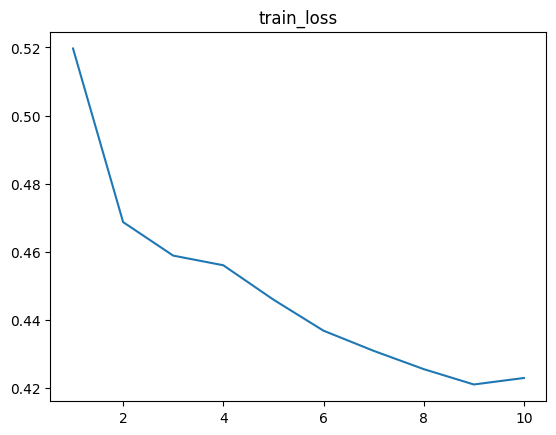

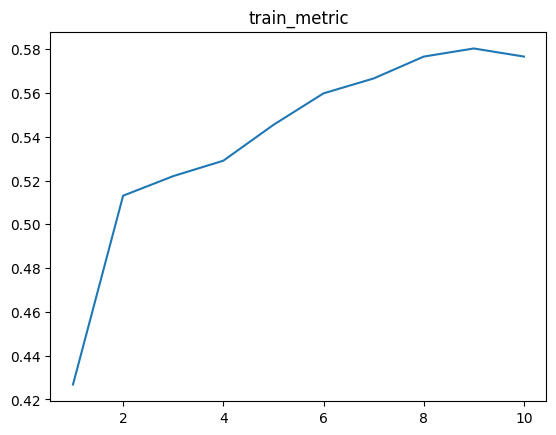

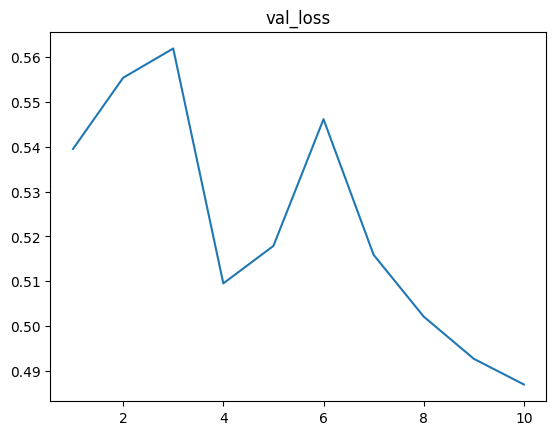

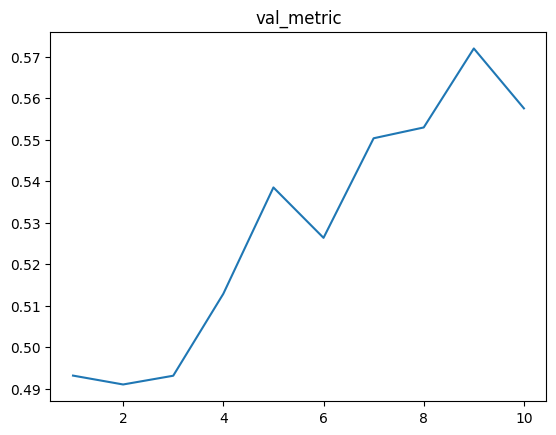

In [22]:
for key, value in result_2.items():
    plotting(value, key)

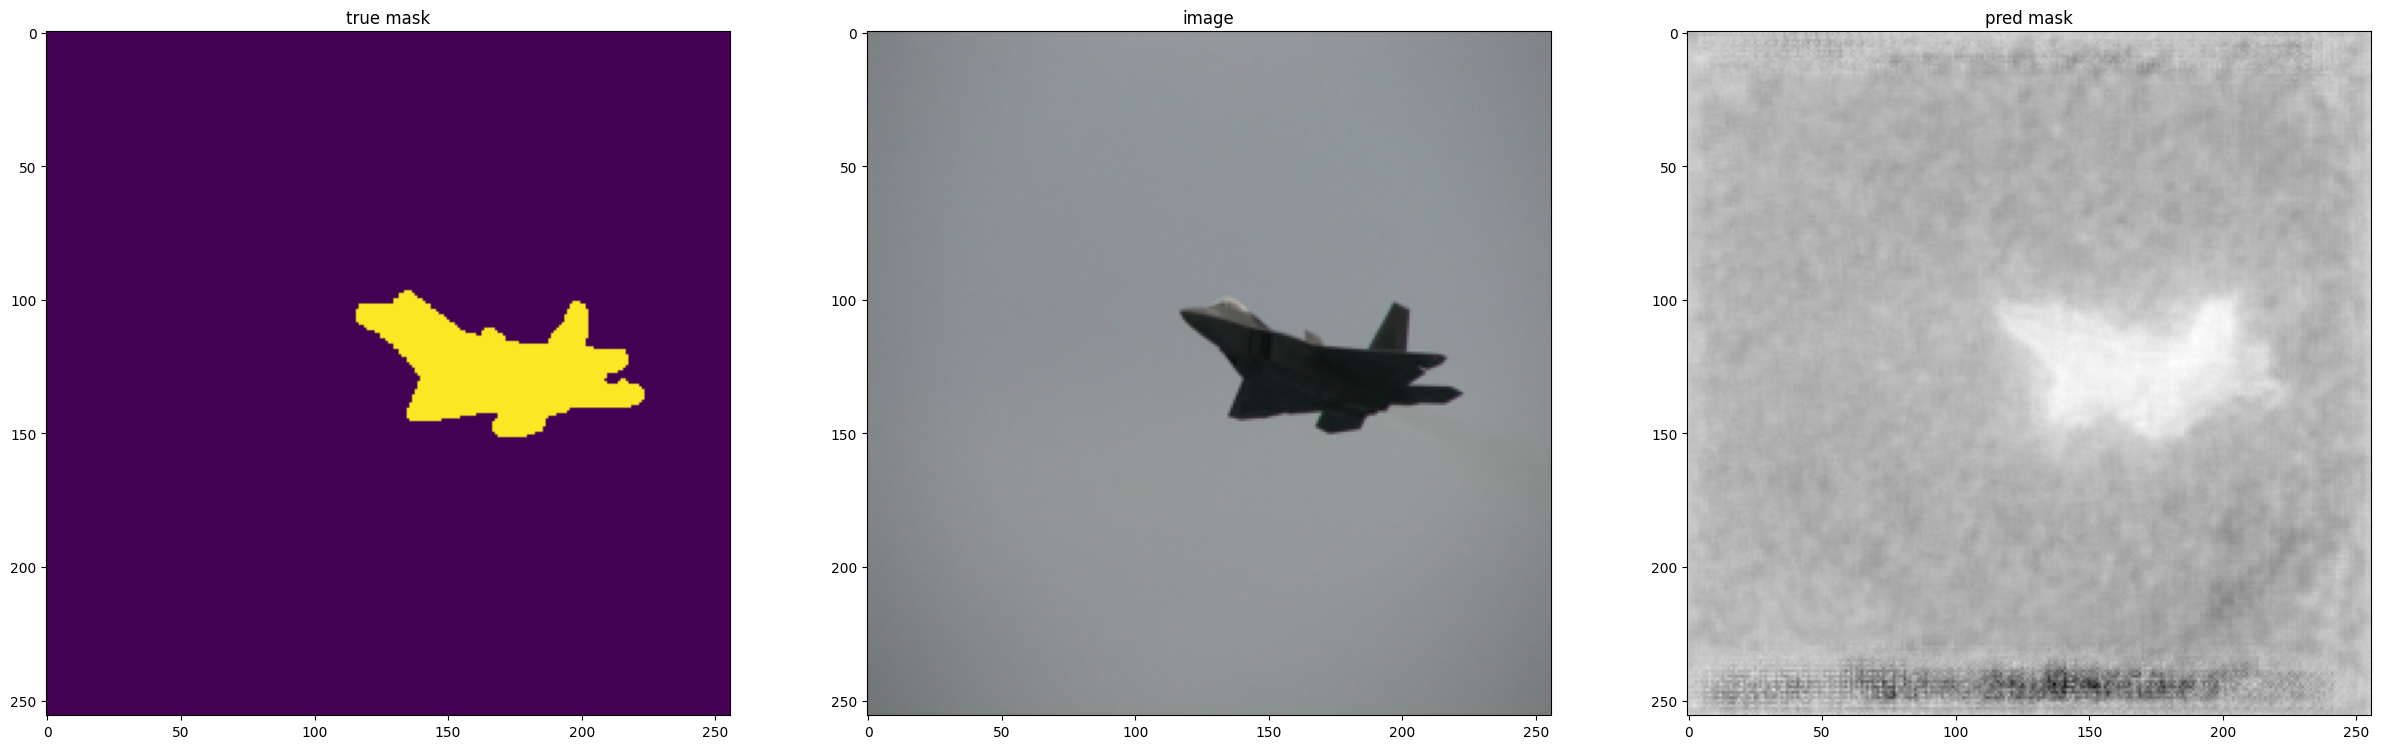

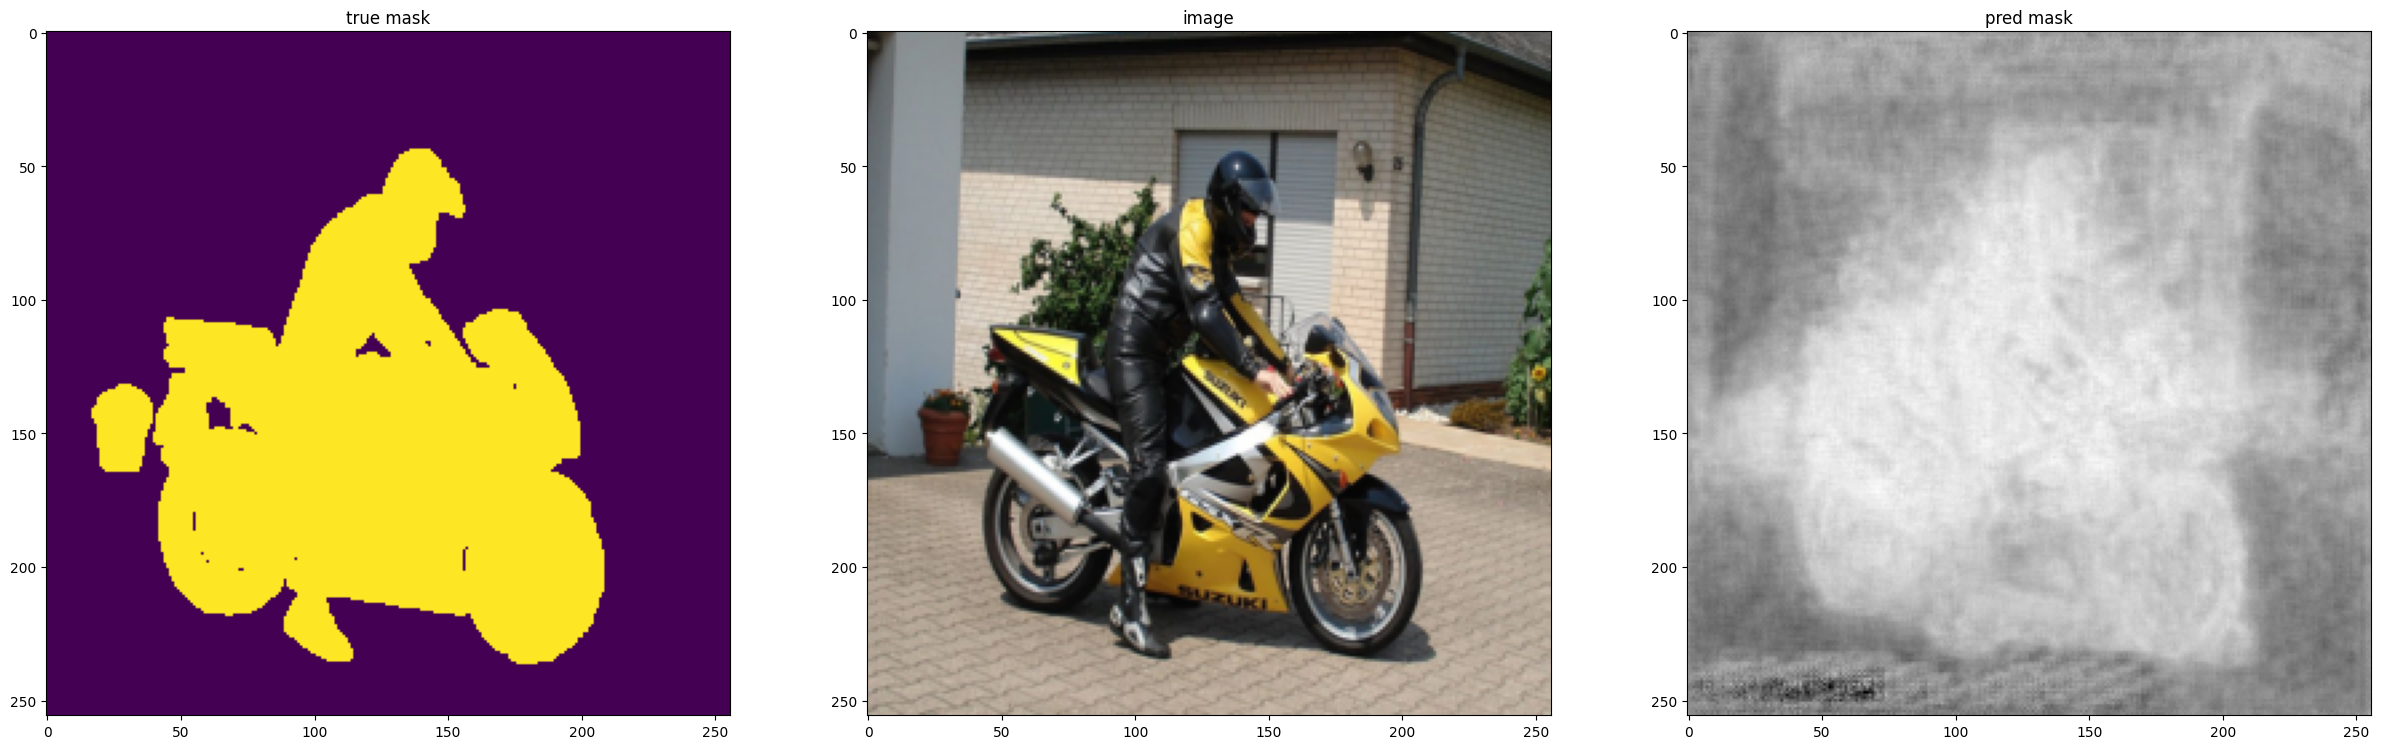

In [23]:
draw_results(model, val_dataloader, device, 2)

In [24]:
draw_results(model, train_dataloader, device, 2)

Output hidden; open in https://colab.research.google.com to view.

**BCEWithLogitsLoss + BinaryDiceLoss**

In [25]:
model = SegNet(num_classes=1, hidden_channels=64)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss = combined_loss
metric = mean_iou
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10

In [26]:
# BCEWithLogitsLoss + DiceLoss
result_3 = train(model, train_dataloader, val_dataloader, optimizer, loss, mean_iou, device, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1, train_loss: 1.1419, train_metric: 0.4747
EPOCH: 1, val_loss: 1.0870, val_metric: 0.4958
EPOCH: 2, train_loss: 1.0211, train_metric: 0.5153
EPOCH: 2, val_loss: 1.2872, val_metric: 0.4343
EPOCH: 3, train_loss: 1.0799, train_metric: 0.4957
EPOCH: 3, val_loss: 1.2937, val_metric: 0.4482
EPOCH: 4, train_loss: 1.0103, train_metric: 0.5201
EPOCH: 4, val_loss: 1.0100, val_metric: 0.5251
EPOCH: 5, train_loss: 0.9419, train_metric: 0.5461
EPOCH: 5, val_loss: 0.9924, val_metric: 0.5331
EPOCH: 6, train_loss: 0.9267, train_metric: 0.5513
EPOCH: 6, val_loss: 0.9408, val_metric: 0.5491
EPOCH: 7, train_loss: 0.8940, train_metric: 0.5650
EPOCH: 7, val_loss: 0.9425, val_metric: 0.5516
EPOCH: 8, train_loss: 0.8689, train_metric: 0.5758
EPOCH: 8, val_loss: 0.9457, val_metric: 0.5455
EPOCH: 9, train_loss: 0.8705, train_metric: 0.5742
EPOCH: 9, val_loss: 0.9930, val_metric: 0.5350
EPOCH: 10, train_loss: 0.8629, train_metric: 0.5778
EPOCH: 10, val_loss: 0.9610, val_metric: 0.5368


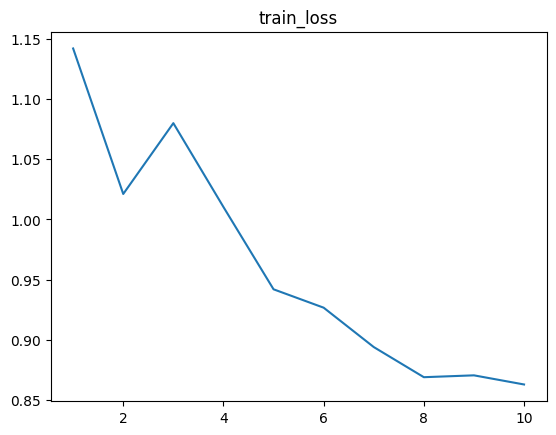

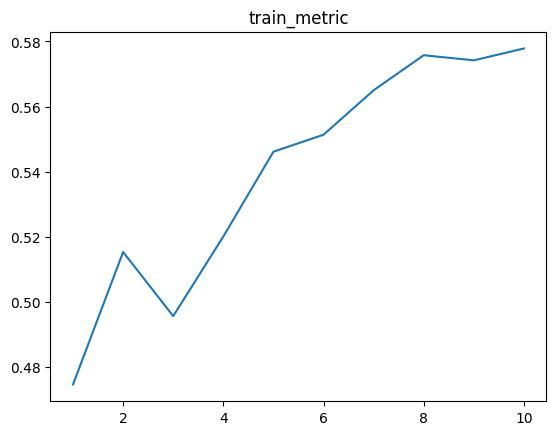

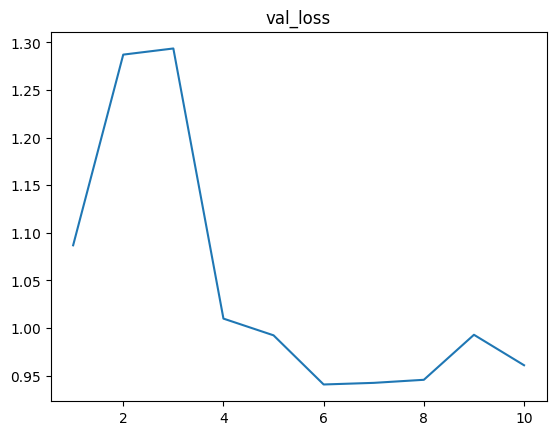

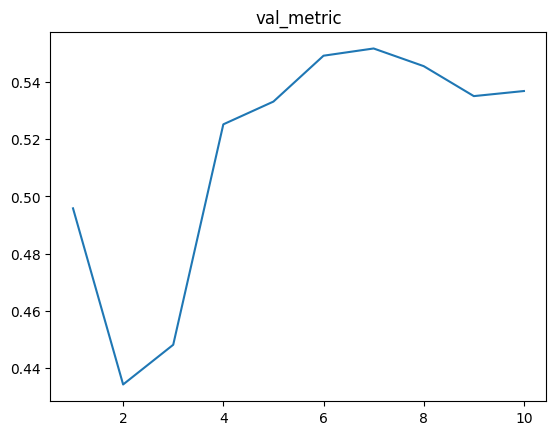

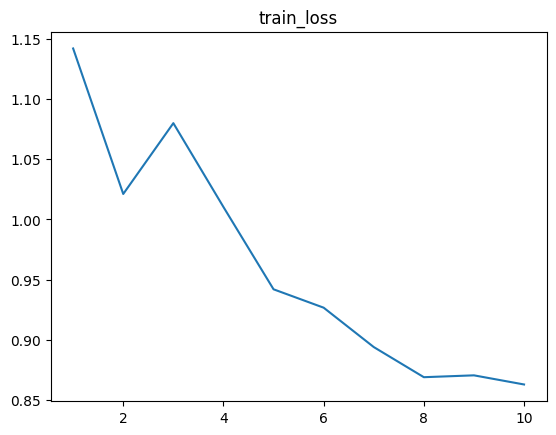

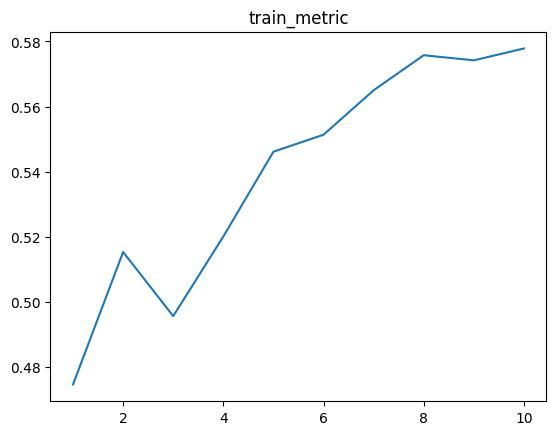

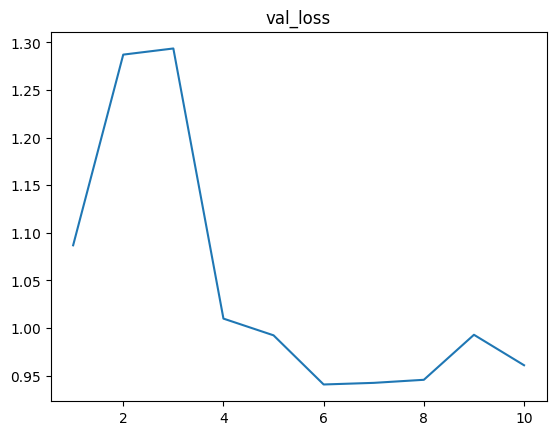

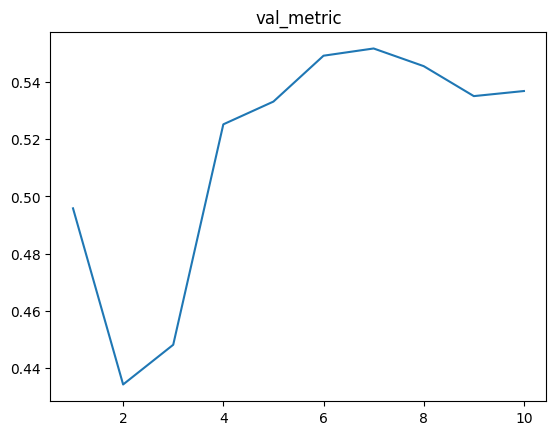

In [32]:
for key, value in result_3.items():
    plotting(value, key)

In [33]:
draw_results(model, val_dataloader, device, 2)

Output hidden; open in https://colab.research.google.com to view.

In [34]:
draw_results(model, train_dataloader, device, 2)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
class NewSegNet(nn.Module):
    @staticmethod
    def make_layers_down(in_channels, hidden_channels, extra_conv=False):
        """Создаёт блок энкодера из двух или трёх сверток"""

        layers = [
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU()
        ]

        if extra_conv:
            layers.extend([
                nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(hidden_channels),
                nn.ReLU()
            ])

        enc_conv = nn.Sequential(*layers)
        pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        return enc_conv, pool

    @staticmethod
    def make_layers_up(in_channels, hidden_channels, extra_conv=False):
        """Создаёт блок декодера из двух или трёх сверток"""

        upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU()
        ]

        if extra_conv:
            layers = [
                nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(in_channels),
                nn.ReLU()
            ] + layers

        dec_conv = nn.Sequential(*layers)
        return upsample, dec_conv

    def __init__(self, num_classes, hidden_channels):
        super().__init__()
        self.num_classes = num_classes
        self.hidden_channels = hidden_channels

        """ENCODER. 5 stages"""
        # feature map 3 --> 64
        self.enc_conv0, self.pool0 = SegNet.make_layers_down(3, self.hidden_channels)

        # feature map 64 --> 128
        self.enc_conv1, self.pool1 = SegNet.make_layers_down(
            self.hidden_channels,
            self.hidden_channels * 2,
            True
        )

        # feature map 128 --> 256
        self.enc_conv2, self.pool2 = SegNet.make_layers_down(
            self.hidden_channels * 2,
            self.hidden_channels * 4,
            True
        )

        # feature map 256 --> 512
        self.enc_conv3, self.pool3 = SegNet.make_layers_down(
            self.hidden_channels * 4,
            self.hidden_channels * 8,
            True
        )

        # feature map 512 --> 512
        self.enc_conv4, self.pool4 = SegNet.make_layers_down(
            self.hidden_channels * 8,
            self.hidden_channels * 8,
            True
        )

        """DECODER. 5 stages correspond to their counterparts in ENCODER"""
        # feature map 512 --> 512
        self.upsample4, self.dec_conv4 = SegNet.make_layers_up(
            self.hidden_channels * 8,
            self.hidden_channels * 8,
            True
        )

        # feature map 512 --> 256
        self.upsample3, self.dec_conv3 = SegNet.make_layers_up(
            self.hidden_channels * 8,
            self.hidden_channels * 4,
            True
        )

        # feature map 256 --> 128
        self.upsample2, self.dec_conv2 = SegNet.make_layers_up(
            self.hidden_channels * 4,
            self.hidden_channels * 2,
            True
        )

        # feature map 128 --> 64
        self.upsample1, self.dec_conv1 = SegNet.make_layers_up(
            self.hidden_channels * 2,
            self.hidden_channels,
        )

        # feature map 64 --> num_classes
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(
                self.hidden_channels,
                self.hidden_channels,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(self.hidden_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(
                self.hidden_channels,
                self.num_classes,
                kernel_size=3,
                padding=1
            )
        )

    def forward(self, x):
        # ENCODING
        x, idx0 = self.pool0(self.enc_conv0(x))
        size0 = x.size()

        x, idx1 = self.pool1(self.enc_conv1(x))
        size1 = x.size()

        x, idx2 = self.pool2(self.enc_conv2(x))
        size2 = x.size()

        x, idx3 = self.pool3(self.enc_conv3(x))
        size3 = x.size()

        x, idx4 = self.pool4(self.enc_conv4(x))

        # DECODING
        x = self.dec_conv4(self.upsample4(x, idx4, output_size=size3))
        x = self.dec_conv3(self.upsample3(x, idx3, output_size=size2))
        x = self.dec_conv2(self.upsample2(x, idx2, output_size=size1))
        x = self.dec_conv1(self.upsample1(x, idx1, output_size=size0))
        x = self.dec_conv0(self.upsample0(x, idx0))
        x = torch.sigmoid(x)

        return x

In [42]:
model = NewSegNet(num_classes=1, hidden_channels=64)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss = nn.BCELoss()
metric = mean_iou
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10

In [43]:
# BCELoss + NewSegNet
result_4 = train(model, train_dataloader, val_dataloader, optimizer, loss, mean_iou, device, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1, train_loss: 0.5436, train_metric: 0.1370
EPOCH: 1, val_loss: 0.5255, val_metric: 0.1487
EPOCH: 2, train_loss: 0.4475, train_metric: 0.1372
EPOCH: 2, val_loss: 0.5142, val_metric: 0.1486
EPOCH: 3, train_loss: 0.4331, train_metric: 0.1362
EPOCH: 3, val_loss: 0.5100, val_metric: 0.1489
EPOCH: 4, train_loss: 0.4336, train_metric: 0.1371
EPOCH: 4, val_loss: 0.5155, val_metric: 0.1493
EPOCH: 5, train_loss: 0.4296, train_metric: 0.1367
EPOCH: 5, val_loss: 0.4925, val_metric: 0.1490
EPOCH: 6, train_loss: 0.4251, train_metric: 0.1370
EPOCH: 6, val_loss: 0.5167, val_metric: 0.1485
EPOCH: 7, train_loss: 0.4202, train_metric: 0.1364
EPOCH: 7, val_loss: 0.5082, val_metric: 0.1492
EPOCH: 8, train_loss: 0.4180, train_metric: 0.1372
EPOCH: 8, val_loss: 0.4872, val_metric: 0.1490
EPOCH: 9, train_loss: 0.4127, train_metric: 0.1363
EPOCH: 9, val_loss: 0.4895, val_metric: 0.1485
EPOCH: 10, train_loss: 0.4072, train_metric: 0.1362
EPOCH: 10, val_loss: 0.4909, val_metric: 0.1486


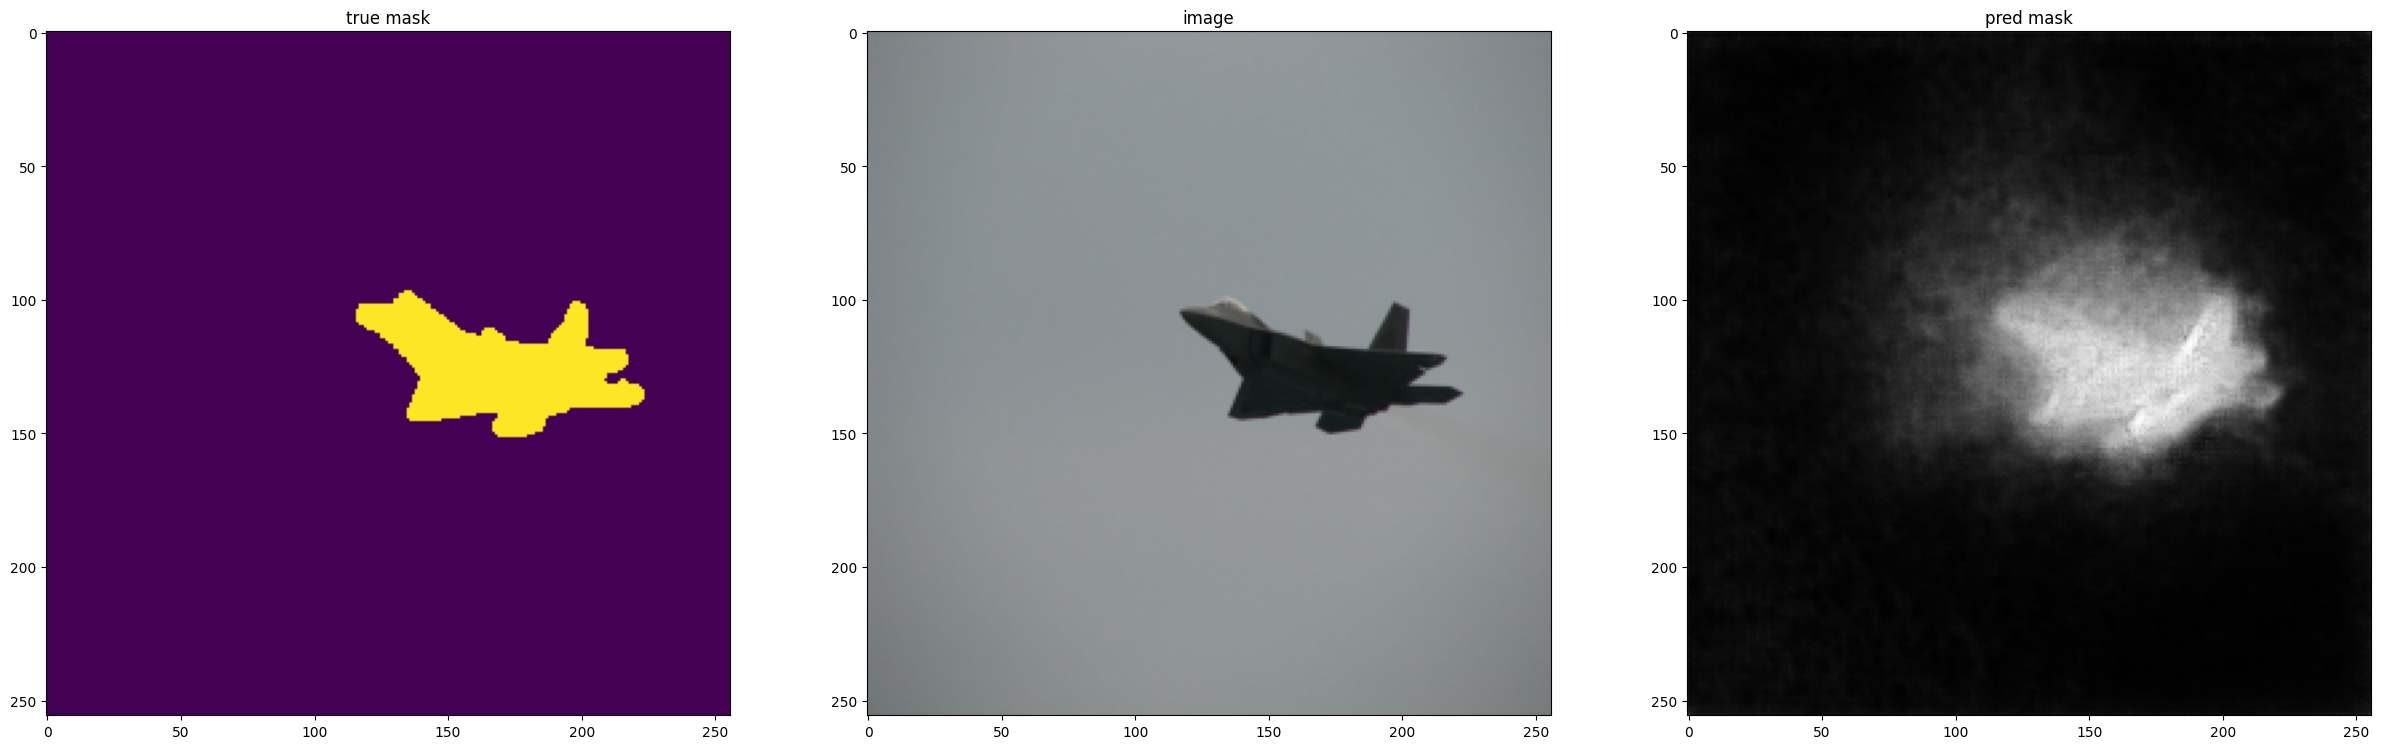

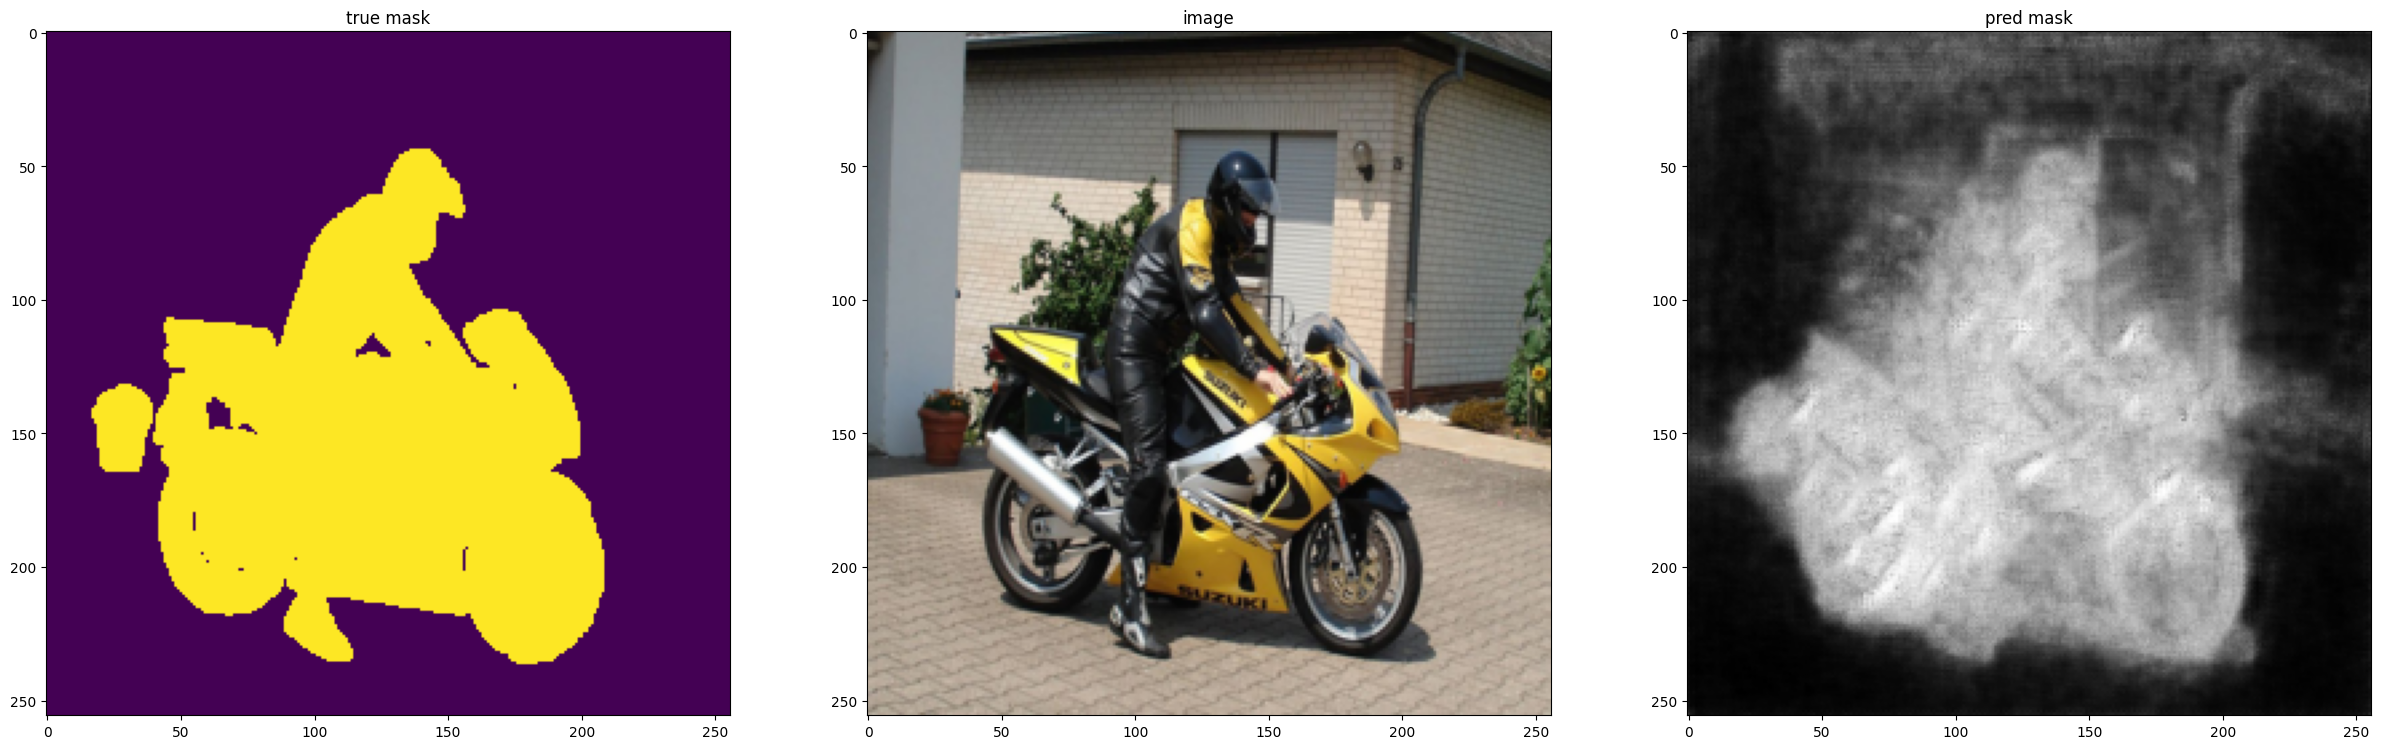

In [44]:
draw_results(model, val_dataloader, device, 2)

In [45]:
draw_results(model, train_dataloader, device, 2)

Output hidden; open in https://colab.research.google.com to view.